# Light transport simulation 

This simulation achieves its efficiency due to the assumption of a uniform, shadowless medium, which enables us to re-use the same simulated emission and detection fields for all emitting and detecting elemnts.

## Emission fields

The algorithm in class `Space` computes the photon irradiance in the volume surrounding a light emitter. 

The result is the 3D array $q_e(\mathbf z)$ containing the probability of an emitted photon passing through a sphere with cross-section of 1 $\mu m^2$ at point $\mathbf z$.

Note that $q_e(\mathbf z)$ is not a probability density function. Although it's nonnegative, it can exceed 1.0 and the integral 
$$\ell = \iiint_{\mathbf z \in \Omega} q_e(\mathbf z) d \mathbf z$$ 
evaluates the average travel length of an emitted photon within the integrated region $\Omega$.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from photonics.space import Space

# Emitter Tests

In [2]:
# basic sanity check that the choice of the voxel pitch has no effect
# on the result such as the average photon travel length 
# within the volume.

for pitch in (1, 2, 4):
    space = Space(dims=(1000//pitch, 1000//pitch, 1000//pitch), pitch=pitch)
    space.run(iterations=2000)
    print(f'Average travel for pitch={pitch} um is {space.volume.sum()*space.pitch**3} um')

100%|██████████| 2000/2000 [00:06<00:00, 286.34it/s]


Average travel for pitch=1 um is 810.616943359375 um


  2%|▏         | 30/2000 [00:00<00:06, 298.23it/s]

Average travel for pitch=2 um is 809.340087890625 um


100%|██████████| 2000/2000 [00:04<00:00, 407.24it/s]

Average travel for pitch=4 um is 807.3486328125 um


100%|██████████| 20000/20000 [01:02<00:00, 321.82it/s]


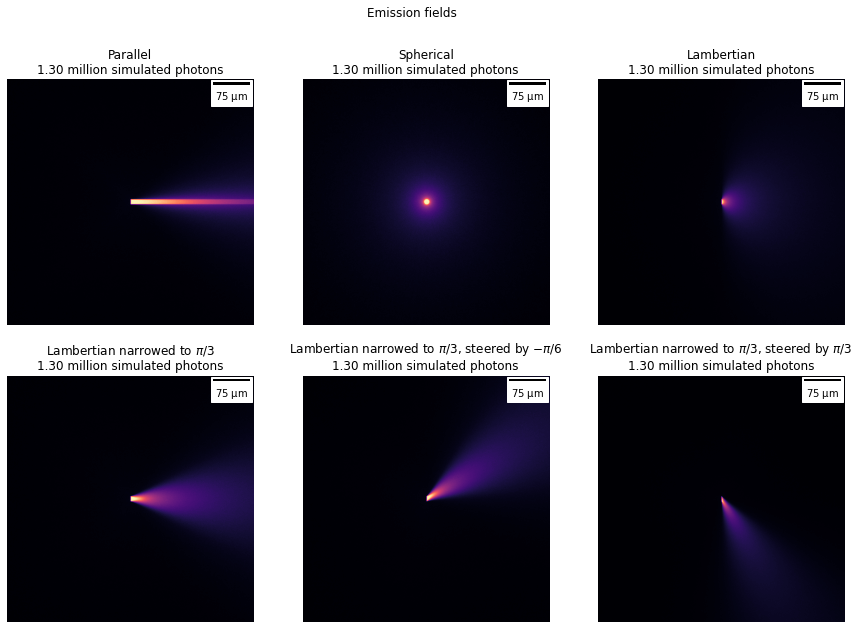

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = iter(ax.flatten())

iterations = 20_000
display_gamma = 0.7
cmap = 'magma'

fig.suptitle('Emission fields')

space = Space(emitter_spread="parallel")
space.run(iterations)
space.plot(next(ax), "Parallel", gamma=display_gamma, cmap=cmap)

space = Space(emitter_spread="spherical", emitter_shape="sphere", emitter_size=(10,10,10))
space.run(iterations)
space.plot(next(ax), "Spherical", gamma=display_gamma, cmap=cmap)

space = Space()
space.run(iterations)
space.plot(next(ax), "Lambertian", gamma=display_gamma, cmap=cmap)

space = Space(beam_compression=1/3)
space.run(iterations)
space.plot(next(ax), "Lambertian narrowed to $\pi/3$", gamma=display_gamma, cmap=cmap)

space = Space(beam_compression=1/3, y_steer=-np.pi/6)
space.run(iterations)
space.plot(next(ax), "Lambertian narrowed to $\pi/3$, steered by $-\pi/6$", gamma=display_gamma, cmap=cmap)

space = Space(beam_compression=1/3, y_steer=np.pi/3, pitch=0.5, dims=(1000,1000,1000))
space.run(iterations)
space.plot(next(ax), "Lambertian narrowed to $\pi/3$, steered by $\pi/3$", gamma=display_gamma, cmap=cmap)

fig.savefig('emission-sim.pdf')


## Detection fields

If we ignore the shadows from the probe, the same simulation can estimate the detection field $q_d(\mathbf z)$ denoting the probability that a photon originating from point $\mathbf z$ in a random direction gets counted by the detector placed at the origin whose normal is aligned with the z-axis.

For the calculation, the detector is assumed to be a flat patch with a generally non-uniform sensitivity function $s(\mathbf u, \eta)$ of the incident point $\mathbf u$ and angle $\eta$.

A virtual emitter is placed at the origin in the shape of the detector with spherically symmetric emission spread.  Thus photons are emitted from points $\mathbf u$ corresponding to the ultimate impinge point on the detector surface.

While passing through points $\mathbf z$, photons update the irradiance $d(\mathbf z)$ for a detector placed at $\mathbf z$ at the impinge position $\mathbf u$, applying the sensitivity function $s(\mathbf u, \eta)\in [0, 1]$. 

By inverting the coordinates, $q_d(\mathbf z) = \frac 1 2 A d(\mathbf z)$ becomes equivalent to the probability of a photon originating from $-\mathbf z$ getting counted, where $A$ is the detector area. $\mathbf u$ is drawn uniformly from that area. Generally, the maximum detection probability is near the surface of detectors, approaching $0.5 \times DQE$.

## Detector tests
To convert the test from emission field calculation to detection field, change `detector type` from `"total"` and `emission_spread` to `"spherical"`.

  0%|          | 36/10000 [00:00<00:27, 358.02it/s]

Max detection probabililty = 0.46990206465125084


100%|██████████| 10000/10000 [00:25<00:00, 398.74it/s]


Max detection probabililty = 0.07579796947538853


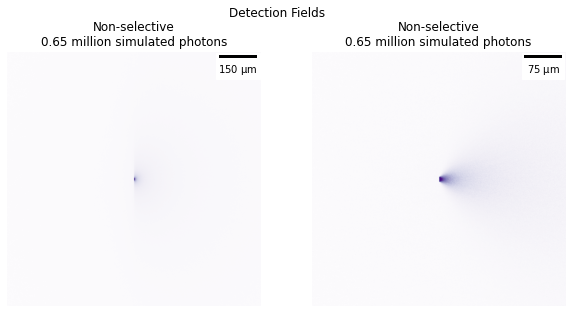

In [17]:
fig, axx = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Detection fields')

space1 = Space(detector_type="one-sided", emitter_spread="spherical", pitch=1, dims=(1000,1000,1000))
space2 = Space(detector_type="narrowed", emitter_spread="spherical")

for space, ax, title in zip((space1, space2), axx, ('non-selective', '$\cos^4$ selectivity')):
    space.run(10_000)
    space.plot(ax, "Non-selective", gamma=0.7, cmap="Purples")
    print(f"Max detection probabililty = {0.5*space.volume.max()*space.emitter_area}")

fig.suptitle('Detection Fields')
fig.savefig('detection-sim.pdf')

In [ ]:
!open detection-sim.pdf

In [ ]:
!open emission-sim.pdf